In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import wikipedia
import regex as re
from tqdm import tqdm
import seaborn as sn
import pickle
import csv
import scipy
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Preprocessing and data visualization

In [3]:
df=pd.read_csv('/content/drive/My Drive/Kaggle_competition/train.csv', sep=',')
df = df.rename(columns={'sex': 'age1'})
df = df.rename(columns={'age': 'sex'})
df = df.rename(columns={'age1':'age'})
df = df.rename(columns={'release_date' : 'genre'})
df['genre'] = df['genre'].str.split('|')
df['sex'] = df['sex'].replace('M',1)
df['sex'] = df['sex'].replace('F',0)
df['age'] = (df['age']-df['age'].mean())/(df['age'].std())

The database has 800167 ratings
The database has 6040 users
The database has 3680 movies


The number of male users is 0
The number of female users is 0




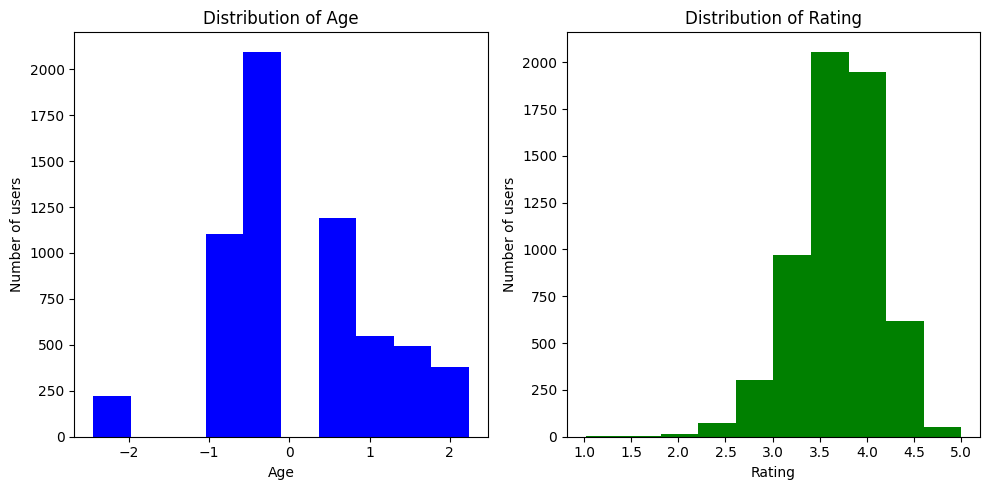



There are 478 movies with less that 10 ratings


In [ ]:
print('The database has {} ratings'.format(len(df)))
print('The database has {} users'.format(len(set(df.user_id))))
print('The database has {} movies'.format(len(set(df.title))))


print('\n')

#Let us now understand how the users are distributed according to the rating, sex and age.
df_grouped = df.groupby('user_id').agg({'rating': 'mean', 'sex': 'first', 'age': 'first'}).reset_index()
counter_female=len(df_grouped[df_grouped['sex']=='F'])
counter_male=len(df_grouped[df_grouped['sex']=='M'])
print('The number of male users is {}'.format(counter_male))
print('The number of female users is {}'.format(counter_female))
print('\n')


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(df_grouped['age'].values, bins=10, color='blue')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Number of users')
axes[0].set_title('Distribution of Age')

axes[1].hist(df_grouped['rating'].values, bins=10, color='green')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Number of users')
axes[1].set_title('Distribution of Rating')

plt.tight_layout()
plt.show()


print('\n')

#Let us now see the most viewed items and their mean ratings

counter_rating=df.groupby('title').agg({'rating': 'count'})['rating'].values
popular_movies=df.groupby('title').agg({'rating': 'mean'})
popular_movies['ratings_count']=counter_rating
popular_movies.sort_values(by='ratings_count', ascending=False)

#NB

print('There are {} movies with less that {} ratings'.format(len(popular_movies[popular_movies['ratings_count']<10]),10))


We can extract some additional information as the plot

In [ ]:
# Let us now add some more information on the movie as the plot.

def get_wikipedia_page_name(raw_name):
    names = wikipedia.search(raw_name)
    if len(names) == 0:
      return ''
    else:
      return names[0]

def get_movie_plot(page_name):
    try:
      try:
        movie_page_content = str(wikipedia.page(page_name, auto_suggest=False).content)
      except wikipedia.DisambiguationError as e:
        for option in e.options:
          if 'film' in option:
            movie_page_content = str(wikipedia.page(option, auto_suggest=False).content)
        return ''
    except (wikipedia.PageError, KeyError):
      return ''
    re_groups = re.search("Plot ==(.*?)=+ [A-Z]", str(movie_page_content).replace('\n', ''))
    if re_groups:
      return re_groups.group(1)
    else:
      return ''

tqdm.pandas()


# MAYBE IT IS BETTER TO WORK ONLY WITH THE DATASET GROUPED BY TITLE, SO THAT IT WILL BE FASTER

#movies_df['wikipedia_page_name'] = movies_df['title'].progress_apply(lambda name: get_wikipedia_page_name(name))
#movies_df['movie_plot'] = movies_df['wikipedia_page_name'].progress_apply(lambda page_name: get_movie_plot(page_name))

In [ ]:
with open('/content/drive/My Drive/Kaggle_competition/movies_with_plot.pkl', 'rb') as f:
  movies_df=pickle.load(f)

print('there are {} empty movie plots'.format(len(movies_df[movies_df["movie_plot"]==''])))
movies_df[['title', 'movie_plot']].head()

there are 580 empty movie plots


,title,movie_plot
0,Top Gun (1986),
1,12 Angry Men (1957),"On a hot summer day, a jury in the New York Co..."
2,Robocop 2 (1990),"In a near dystopian future, Detroit is nearing..."
3,Modern Times (1936),"The Tramp works on an assembly line, where he ..."
4,Milk Money (1994),"Three boys — Brad (Adam LaVorgna), Frank (Mich..."


### Building the recommender system

In [ ]:
# Base Class

class TopPopRecommender():

    def fit(self, train):

        item_popularity = train[['movie_id','rating']].groupby(by='movie_id').count()
        self.train = train
        # We are not interested in sorting the popularity value, but to order the items according to it
        self.popular_items = item_popularity.sort_values(by='rating',ascending=False).index


    def predict_top(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            seen_items = self.train[self.train.user_id==user_id].movie_id.values
            unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert = True)
            unseen_items = self.popular_items[unseen_items_mask]
            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]

        return recommended_items

We can take the items for each user that he watched, for each movie he watched $m_1,\ldots m_s$ we can collect the similar movies $L_1,\ldots,L_s$ where $L_i$ are lists. The final list we are going to recommend is
$$ w_1L_1+\ldots+w_sL_s \quad \text{where}\,\, w_i=\frac{score_i}{5}$$

Even tough it produces a good output, the algorithm it is very slow due to the huge number of iterations: combining sorting and weighting all the list (and there are users with 300 movies rated) it is a long task. As a consequence we wrrite the function, but we will apply other method that speed up the collaborative filtering approach


In [ ]:
from sklearn.neighbors import NearestNeighbors

class item_item_filtering:

    def __init__(self, train):
        self.train=train
        self.item_user_df=self.train.pivot_table(values='rating',index='title', columns='user_id')
        self.item_user_df=self.item_user_df.fillna(0)
        self.matrix=self.item_user_df.values

    def item_distance(self,metric='cosine'):
        self.metric=metric
        self.model= NearestNeighbors(metric=self.metric,n_neighbors=10,algorithm='brute') # we use a predetermined distance and brute force algorithm to get the nearest movies
        self.model.fit(self.matrix)



    def predict_top(self, user_id, at=5, remove_seen=True):
        self.user_id=user_id
        if remove_seen:
            seen_items = self.train[self.train.user_id == self.user_id].title.values
            ratings = self.train[self.train.user_id == self.user_id].rating.values
            distances_sum = np.zeros(len(self.item_user_df))
            i = 0
            for item in seen_items:
                location_of_item = self.item_user_df.loc[item].values.reshape(1, -1)
                distances, indices = self.model.kneighbors(location_of_item, n_neighbors=len(self.item_user_df))
                sorted_indices = np.argsort(indices.squeeze())
                ordered_distance = distances.squeeze()[sorted_indices]
                distances_sum += (ratings[i]/5)*ordered_distance
                i += 1

            # We get the "general" closest films
            top_indices = np.argsort(distances_sum)
            top_indices=[idx for idx in top_indices if self.item_user_df.index[idx] not in seen_items]
            top_indices = np.argsort(distances_sum)[:at]


        else:
            pass

        # Get top movies by indices
        top_movies = self.item_user_df.iloc[top_indices].index.tolist()
        #top_movies_indx = self.train[self.train['title'].isin(top_movies)]['movie_id'].tolist()


        return top_movies


In [ ]:
item_filter = item_item_filtering(df)
item_filter.item_distance()
movies=item_filter.predict_top(user_id=1,at=25)


In [ ]:
print(movies)

['Toy Story (1995)', 'E.T. the Extra-Terrestrial (1982)', 'Aladdin (1992)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Big (1988)', 'Beauty and the Beast (1991)', 'Lion King, The (1994)', 'Back to the Future (1985)', 'Fargo (1996)', 'Groundhog Day (1993)', 'Princess Bride, The (1987)', "Schindler's List (1993)", 'Raiders of the Lost Ark (1981)', 'Wizard of Oz, The (1939)', 'Shawshank Redemption, The (1994)', 'Ghostbusters (1984)', 'Who Framed Roger Rabbit? (1988)', 'Silence of the Lambs, The (1991)', "Ferris Bueller's Day Off (1986)", 'Sixth Sense, The (1999)', 'Star Wars: Episode IV - A New Hope (1977)', 'Pulp Fiction (1994)', 'Shakespeare in Love (1998)', 'Little Mermaid, The (1989)', 'Apollo 13 (1995)']


Similarly, we can compute a function that is user-user based. Essentially you retreive the top k similar users and predict the score for the item based on their ratings and the similarity. The same problem of the previous function: this requires too computational cost

In [ ]:
class user_user_filtering:
    def __init__(self, train):
        self.train=train
        self.user_item_df=self.train.pivot_table(values='rating',index='user_id',columns='title')
        self.user_item_df=self.user_item_df.fillna(0)
        self.matrix=self.user_item_df.values

    def predict_top(self, user_id, at=25,k=10, min_visual=10): # k refers to how many users we want to consider for the similarity measure
        # we have another hyperparameter to set min_visual to consider only movies with at least that amount of ratings
        # Let us compute the pearson correlation between. First we localize the user
        location_of_user=self.user_item_df.iloc[user_id].values
        seen_movies=self.train[self.train['user_id']==user_id].title.values # List of seen_movies by that user
        predictions={}
        for item in self.user_item_df.columns:
            if item not in seen_movies and len(self.user_item_df[item].values.nonzero()[0]) >= min_visual:
                # For the movie new to the user we have to take the top k similar users and then retreive their rating.
                # we filter and get only the users who saw that movie:
                list_of_users=self.user_item_df[item].values.nonzero()[0]
                similarities=[pearsonr(location_of_user, self.user_item_df.iloc[user].values)[0] for user in list_of_users]
                indices=np.argsort(similarities)[::-1] # I get the indices of the sorting, so that I get now sort the list of users accordingly
                # and we reverse the order to get the correct ordering.
                similarities.sort(reverse=True)
                list_of_users = [list_of_users[i] for i in indices]
                top_k_similarity, top_k_similar_user= similarities[:k], list_of_users[:k]

                predictions[item] = sum(self.user_item_df.iloc[user][item] * similarity for user, similarity in zip(top_k_similar_user, top_k_similarity))
                predictions[item] /= sum(top_k_similarity)
            else:

                predictions[item]=0 # we set at 0 the unpopular movies and the one the user already saw

        top_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:at][0] #we sort by the prediction value. (title, value)---> we want only title
        top_predictions = [movie for movie, _ in top_predictions] # we compress the list and get only title
        return top_predictions

### Content based algorithm
Let us try using the plot of each movie, filtering out the movie without plot and extract features from the plot

In [ ]:
movies_df=movies_df[['title','movie_plot']] # we use only this two columns
film_to_discard=movies_df[movies_df['movie_plot']==''].index.tolist()
movies_df=movies_df.drop(index=film_to_discard) # ---> we have only the movies with the plot

In [ ]:
from gensim.models import FastText
from gensim.utils import simple_preprocess

corpus = [simple_preprocess(text) for text in movies_df['movie_plot']]

#model = FastText(corpus, vector_size=100, window=5, min_count=5, workers=4)


features = [model.wv[sentence].mean(axis=0) for sentence in corpus]


In [ ]:
with open('/content/drive/My Drive/Kaggle_competition/fasttext_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('/content/drive/My Drive/Kaggle_competition/fasttext_model.pkl', 'rb') as f:
  model=pickle.load(f)



In [ ]:
movie_names = movies_df['title']
features_df = pd.DataFrame(np.array(features), index=movie_names)

In [ ]:
features_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
title,,,,,,,,,,,,,,,,,,,,,
12 Angry Men (1957),0.116636,0.131939,-0.053089,0.235756,0.268846,0.036022,-0.288392,-0.352042,-0.048947,-0.130516,...,-0.730682,-0.542913,-0.344404,-0.332319,-0.216467,0.553368,-0.316817,0.015656,0.338032,-0.062145
Robocop 2 (1990),-0.147733,0.389549,0.173179,0.259479,0.177102,0.137622,-0.119773,-0.149780,0.043410,-0.310744,...,-1.049170,-0.602655,-0.413732,-0.095504,-0.123799,0.801323,-0.210446,0.008185,0.249190,0.164412
Modern Times (1936),0.094728,-0.028272,0.177645,0.408857,0.255804,-0.102344,0.131573,-0.345416,-0.198424,-0.078696,...,-0.646205,-0.583898,-0.530643,-0.085532,-0.088053,0.572450,-0.190905,-0.158022,0.345181,0.070060
Milk Money (1994),0.135162,0.049762,0.293267,0.273308,0.400925,-0.208498,0.153242,-0.665610,-0.277379,-0.170587,...,-0.535271,-0.472622,-0.519451,-0.085634,-0.024197,0.753364,-0.343501,0.006336,0.267821,0.143144
Flashdance (1983),-0.020506,0.222236,-0.025717,0.112775,0.111951,0.022310,-0.112443,-0.163485,0.074775,0.001099,...,-0.555670,-0.397515,-0.256379,-0.178948,-0.148281,0.568165,-0.255488,-0.098266,0.158923,0.035971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Night Tide (1961),0.167761,0.129828,0.002371,0.257993,0.210996,-0.057328,-0.057017,-0.379637,-0.015494,-0.129917,...,-0.498360,-0.592662,-0.463109,-0.225748,-0.221350,0.494009,-0.277664,-0.139928,0.341901,0.051934
Mirage (1995),0.490850,-0.042279,0.188699,0.411168,0.192646,-0.140223,0.005377,-0.493390,-0.349866,0.029916,...,-0.503646,-0.547299,-0.833808,-0.138033,-0.169585,0.382517,-0.237151,0.171932,0.182506,-0.170896
Ménage (Tenue de soirée) (1986),-0.013139,0.022771,0.140170,0.159499,-0.013665,-0.009651,0.332952,-0.444707,0.167891,-0.056856,...,-0.741902,-0.188199,-0.561456,-0.074699,-0.170748,0.494144,-0.187027,-0.196112,0.320391,0.545883


Let us try an alternative approach to compute the closest points to a given set of points $K$

In [ ]:
features_df.values

array([[ 0.11663623,  0.13193907, -0.05308876, ...,  0.01565617,
         0.33803248, -0.06214501],
       [-0.14773344,  0.3895487 ,  0.17317939, ...,  0.00818549,
         0.24919002,  0.16441199],
       [ 0.09472845, -0.02827178,  0.17764543, ..., -0.15802158,
         0.34518066,  0.07005969],
       ...,
       [-0.01313945,  0.02277102,  0.14016953, ..., -0.19611223,
         0.32039142,  0.5458827 ],
       [ 0.2229685 ,  0.02012946,  0.01741686, ..., -0.04517568,
         0.2692437 ,  0.01569437],
       [-0.063177  ,  0.44940042,  0.06167541, ..., -0.02056546,
         0.29566213,  0.18249328]], dtype=float32)

In [ ]:
# Let us create a matrix of distances in order to use kneighborh
from sklearn.neighbors import NearestNeighbors

distance_model=NearestNeighbors(metric='cosine',n_neighbors=10,algorithm='brute')
distance_model.fit(features_df.values)

def get_prediction_features(user_id, at=25, min_value=4):

    seen_movies=df[(df['user_id'] ==user_id) & (df['rating'] >=min_value)]['title'].tolist()
    # we retreive the list of movies he watched
    # we compute the mean value
    seen_movie_plot=[movie for movie in seen_movies if movie in features_df.index.tolist()]
    mean_movie=mean_movie = np.mean(features_df.loc[seen_movie_plot].values, axis=0).reshape(1, -1) # This characterize the user
    distances, indices = distance_model.kneighbors(mean_movie, n_neighbors=len(features_df))
    # We get the "general" closest films the distances and indices are already ordered.
    # We just have to remove in the indices the movies already seen

    filtered_indices = [idx for idx in indices[0] if features_df.index[idx] not in seen_movie_plot]
    recommended_indices = filtered_indices[:at]

    return features_df.index[recommended_indices] # Here we get the titles since the index here is different from the original index because we removed some movies






### Reducing complexity
Let us now reduce the complexity of the task, using the SVD factorization

In [ ]:
from scipy.sparse.linalg import svds

user_item_df=df.pivot_table(values='rating',index='user_id', columns='movie_id').fillna(0) # Matrix user-item
user_ratings_mean = np.mean(user_item_df.values, axis=1)
df_centered= user_item_df.values - user_ratings_mean.reshape(-1, 1) # values centered to reduce bias (6040,3680)
U, sigma, Vt = svds(df_centered, k=50) # We perform the svd with 50 singular values


In [ ]:
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds = pd.DataFrame(all_user_predicted_ratings, columns = user_item_df.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,3.945376,0.168136,-0.108978,-0.050416,0.036455,0.078489,0.068525,0.118202,-0.061573,-0.066524,...,0.050615,0.018477,0.037493,-0.025464,-0.022899,0.344028,0.079230,0.036944,0.055583,0.057253
1,0.840606,0.406794,0.083209,-0.030652,0.002256,0.398733,0.080751,0.042569,0.120415,1.318911,...,-0.053891,-0.008583,-0.012886,0.067297,-0.008375,-0.020881,-0.190107,-0.003188,-0.054340,0.073300
2,1.795872,0.284238,0.134808,-0.087122,-0.034247,-0.094794,-0.197709,0.065507,0.048457,0.627104,...,-0.006635,0.010766,0.014028,0.016875,0.064228,0.031862,0.002027,0.029762,0.015330,0.007234
3,0.583249,-0.129775,-0.027557,0.092831,0.007303,0.235140,-0.037533,-0.021615,0.047352,-0.189063,...,-0.003651,0.003802,-0.005823,-0.012779,-0.064457,-0.125138,-0.011992,-0.032912,-0.007989,-0.039974
4,1.046982,-0.004257,-0.111991,0.056656,-0.161285,0.981193,-0.277286,-0.015338,-0.026312,0.420027,...,0.099256,0.018719,-0.011787,-0.003839,-0.036324,0.167272,0.375386,0.050154,0.120797,0.275232


In [ ]:
def get_prediction(user_id, at=25):
    seen_items = df[df['user_id'] == user_id].movie_id.values  # film già visti
    predicted_ratings = preds.iloc[user_id-1]  # predizioni per l'utente

    # Mascherare i film già visti impostando a -inf i rating corrispondenti
    predicted_ratings.loc[seen_items] = float('-inf')

    # Ordinare i rating predetti in ordine decrescente e prendere i primi "at" film
    top_predictions = predicted_ratings.sort_values(ascending=False).head(at)

    return top_predictions.index.values



```
# Questo è formattato come codice
```

### Matrix Factorization model
In this section we are going to use the function for the matrix factorization

In [4]:
# Utilities
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import keras

In [5]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-1m.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-1m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

def load_ratings(movielens_dir):
    COL_NAME = ['uid','mid','rating','timestamp']
    df = pd.read_csv(movielens_dir / 'ratings.dat',sep='::', header=None, engine='python', names=COL_NAME)
    df.columns=['user_id','movie_id','rating','timestamp']
    return df

def load_movies(movielens_dir):
    COL_NAME = ['mid','movie_name','movie_genre']
    df = pd.read_csv(movielens_dir / 'movies.dat',sep='::', header=None, engine='python', names=COL_NAME, encoding='latin-1')
    df.columns= ['movie_id','title','movie_genre']
    return df

def user_info(movielens_dir):
    #COL_NAME = ['uid','sex','ag','timestamp']
    df = pd.read_csv(movielens_dir / 'users.dat',sep='::', header=None, engine='python')
    df.columns=['user_id','sex','age','feat', 'feat2']
    return df

dataframe = load_ratings(movielens_dir)
user_df= user_info(movielens_dir)

5917549/5917549 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


In [6]:
def preprocess_fact(df):
    user_ids = df["user_id"].unique().tolist()
    user2user_encoded = {x: i for i, x in enumerate(user_ids)}
    userencoded2user = {i: x for i, x in enumerate(user_ids)}
    movie_ids = df["movie_id"].unique().tolist()
    movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
    movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
    df["user"] = df["user_id"].map(user2user_encoded)
    df["movie"] = df["movie_id"].map(movie2movie_encoded)
    df= pd.merge(df,  user_df[['user_id', 'sex', 'age', 'feat']], on='user_id')
    df['sex'] = df['sex'].replace('M',1)
    df['sex'] = df['sex'].replace('F',0)
    num_users = len(user2user_encoded)
    num_movies = len(movie_encoded2movie)
    df["rating"] = df["rating"].values.astype(np.float32)
    min_rating = min(df["rating"])
    max_rating = max(df["rating"])

    return df, num_users, num_movies,min_rating, max_rating

dataframe, num_users, num_movies,min_rating, max_rating=preprocess_fact(dataframe)

In [7]:
from sklearn.model_selection import train_test_split

dataframe['rating']=np.where(dataframe['rating']>=4,1,0)


train, val = train_test_split(dataframe, test_size=0.2, random_state=7)

x_train = train[["user", "movie", "sex", "age"]].values
y_train = train["rating"].values


x_val = val[["user", "movie", "sex", "age"]].values
y_val = val["rating"].values

In [8]:
max_age=max(dataframe['age'].values)
max_age

56

In [9]:
EMBEDDING_SIZE = 20

class RecommenderNetV(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNetV, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_movie_embedding = layers.Embedding(
            num_users+num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_bias = layers.Embedding(num_movies, 1)
        self.sex_bias = layers.Embedding(2, 1) # we have just two values
        self.age_bias = layers.Embedding(max_age, 1)
        self.age_movie_interaction = layers.Dense(1)


    def call(self, inputs):
        user_vector = self.user_movie_embedding(inputs[:, 0])
        movie_vector = self.user_movie_embedding(inputs[:, 1]+ self.num_users)
        user_bias = self.user_bias(inputs[:, 0])
        movie_bias = self.movie_bias(inputs[:, 1])
        age_bias = self.age_bias(inputs[:, 2])
        sex_bias = self.sex_bias(inputs[:,3])

        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        age_movie_interaction = self.age_movie_interaction(tf.concat([movie_vector, age_bias], axis=-1))
        # Add all the components (including bias)

        x = dot_user_movie + user_bias + movie_bias + age_bias + age_movie_interaction
        return x


mf_model = RecommenderNetV(num_users, num_movies, EMBEDDING_SIZE)
mf_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0005))

In [10]:
mf_history = mf_model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5


6252/6252 [==============================] - 39s 6ms/step - loss: 0.2071 - val_loss: 0.1920
Epoch 2/5
6252/6252 [==============================] - 33s 5ms/step - loss: 0.1902 - val_loss: 0.1932
Epoch 3/5
6252/6252 [==============================] - 30s 5ms/step - loss: 0.1914 - val_loss: 0.1944
Epoch 4/5
6252/6252 [==============================] - 32s 5ms/step - loss: 0.1940 - val_loss: 0.1964
Epoch 5/5
6252/6252 [==============================] - 32s 5ms/step - loss: 0.1962 - val_loss: 0.1986


In [11]:
movie_dataframe=load_ratings(movielens_dir)
movie_ids = movie_dataframe["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
user_ids = movie_dataframe["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

In [12]:
movie_df = load_movies(movielens_dir)

In [13]:
def top_recomendations_mat(model_object, user_id, train, movie_df, at = 5):

    movies_watched_by_user = train[train.user_id == user_id]['movie_id']
    sex=train[train.user_id==user_id]['sex'].values[0]
    age=train[train.user_id==user_id]['age'].values[0]

    movies_not_watched = movie_df[~movie_df["movie_id"].isin(movies_watched_by_user.values)]["movie_id"]
    movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched, [[sex]]*len(movies_not_watched), [[age]]*len(movies_not_watched)))

    ratings = model_object.predict(user_movie_array,verbose=0).flatten()
    top_ratings_indices = ratings.argsort()[-at:][::-1]
    recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]

    return recommended_movie_ids


### Predictions

In [14]:
test =pd.read_csv('/content/drive/My Drive/Kaggle_competition/kaggle_baseline.csv')

In [15]:
import csv
from tqdm import tqdm

# open the file in the write mode
with open('/content/drive/MyDrive/Kaggle_competition/solution.csv', 'w', encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(['user_id', 'prediction'])

    # iterate over unique user_ids with tqdm
    for user_id in tqdm(test.user_id.unique(), desc="Processing Users"):
        relevant_items = top_recomendations_mat(mf_model, user_id ,dataframe, movie_df,25)
        list_relevants = ' '.join([str(elem) for elem in relevant_items])
        writer.writerow([str(user_id), list_relevants])


Processing Users: 100%|██████████| 6037/6037 [36:53<00:00,  2.73it/s]


In [ ]:
import csv
from tqdm import tqdm
import random
topPopular = TopPopRecommender()
topPopular.fit(df)

# open the file in the write mode
with open('/content/drive/MyDrive/Kaggle_competition/solution.csv', 'w', encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(['user_id', 'prediction'])

    # iterate over unique user_ids with tqdm
    for user_id in tqdm(test.user_id.unique(), desc="Processing Users"):
        if user_id==4486 or user_id==4349 or user_id==3598:
            relevant_items = topPopular.predict_top(user_id, at=25)
        else:
            relevant_movie=get_prediction_features(user_id, at=25).values
            relevant_items=movie_id_title[movie_id_title['title'].isin(relevant_movie)].movie_id.values
        list_relevants = ' '.join([str(elem) for elem in relevant_items])
        writer.writerow([str(user_id), list_relevants])

Processing Users: 100%|██████████| 6037/6037 [03:29<00:00, 28.81it/s]
